In [242]:
import sys
import pandas as pd
sys.path.append("..")
import seaborn as sns
import nltk
from thefuzz import fuzz

from humor.metric import fuzzy_match_metric
from humor.bipartite_metric import bipartite_metric

In [243]:
import pandas as pd
from thefuzz import fuzz

def bipartite_metric(model_answers: pd.DataFrame, ground_truth: pd.DataFrame):  
    score_matrix = model_answers.apply(
        lambda row_model: ground_truth.apply(
            lambda row_truth: 
                fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
                if row_model["comedian"] == row_truth["comedian"] 
                else None,
        axis=1),
    axis=1) \
        .melt(ignore_index=False) \
        .dropna() \
        .reset_index()
    
    best_match = score_matrix.loc[score_matrix.groupby("index")["value"].idxmax()].reset_index(drop=True)
    
    missing_gt = set(ground_truth.index) - set(best_match["variable"].unique())
    missing_gt = pd.DataFrame({"index": None, "variable": list(missing_gt), "value": 0})
    
    result = best_match.append(missing_gt).groupby("variable").mean().rename(columns={"value": "score"})
    
    over_generation_penalty = len(model_answers) - len(ground_truth)
    penalty_factor = max(over_generation_penalty, 0)  
    
    final_result = result.merge(ground_truth[['comedian']], left_index=True, right_index=True).reset_index(drop=True)
    comedian_scores = final_result.groupby('comedian')['score'].mean().reset_index()
    
    comedian_scores['score'] -= penalty_factor * 0.1  
    
    return comedian_scores


In [244]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')
transcript = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_transcripts.csv')

In [245]:
#ground truth x ground truth
gt = bipartite_metric(ground_truth, ground_truth)
gt.mean()

/tmp/ipykernel_3058768/4253546501.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gt.mean()


score    100.0
dtype: float64

In [246]:
wrong = pd.DataFrame().reindex_like(ground_truth).drop(["laugh_start", "laugh_end"], axis=1)
wrong["comedian"] = ground_truth["comedian"]
wrong["sentence"] = ""
completely_wrong = bipartite_metric(wrong, ground_truth)
completely_wrong.mean()

/tmp/ipykernel_3058768/3677872773.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  completely_wrong.mean()


score    0.0
dtype: float64

In [247]:
#gemma
gemma_metric = bipartite_metric(model, ground_truth)

In [248]:
gemma_metric

,comedian,score
0,Ali_Wong,32.916667
1,Ali_Wong_2,40.428571
2,Anthony_Jeselnik,18.642857
3,Anthony_Jeselnik_2,63.500000
4,Chelsea_Peretti,14.333333
5,Chelsea_Peretti_2,31.636364
6,Donald_Glover,23.625000
7,Donald_Glover_2,24.000000
8,Hasan_Minhaj,36.250000
9,Hasan_Minhaj_2,25.500000


In [250]:
gemma_metric.max()

comedian    Trevor_Noah_2
score           71.333333
dtype: object

In [251]:
model[model["comedian"] == "Trevor_Noah_2"]

,comedian,sentence
111,Trevor_Noah_2,You can't be normal man with a voice like that...
112,Trevor_Noah_2,It just doesn't work. I remember when Nelson M...
113,Trevor_Noah_2,"Everything he did, he'd just be like, 'Ah, kno..."


In [252]:
ground_truth[ground_truth["comedian"] == "Trevor_Noah_2"]

,comedian,laugh_start,laugh_end,sentence
238,Trevor_Noah_2,13.273,17.662,"You can't be running in the streets: ""And a Ki..."
239,Trevor_Noah_2,26.474,27.698,"""Who the hell is this?!"" ""I'm not telling you."""
240,Trevor_Noah_2,60.423,62.326,"People would be like, ""Let him in. Let him in!"""
241,Trevor_Noah_2,74.216,78.397,"""He is so right. We've always got to ask, 'Who..."


In [253]:
gemma_metric.min()

comedian    Ali_Wong
score       5.708333
dtype: object

In [254]:
model[model["comedian"] == "Ali_Wong"]

,comedian,sentence
6,Ali_Wong,It was like the worst experience of my life. I...
7,Ali_Wong,Those of you under 25 probably don't know what...
8,Ali_Wong,It was like the Tesla of my time.
9,Ali_Wong,I'm not trying to be a procrastinator anymore....


In [255]:
ground_truth[ground_truth["comedian"] == "Ali_Wong"]

,comedian,laugh_start,laugh_end,sentence
77,Ali_Wong,21.007,28.986,We were screaming and fighting and yelling and...
78,Ali_Wong,48.803,51.189,We were all required to buy it when we were in...
79,Ali_Wong,56.780,60.001,All because what? It could graph.
80,Ali_Wong,62.470,66.230,It was like the Tesla of my time.
81,Ali_Wong,69.380,71.670,I do know... that I'm gonna have to clean all ...
82,Ali_Wong,93.523,98.684,"Because according to Deepak-Oprah, that's not ..."


In [256]:
gemma_metric["score"].mean() 

28.17159939733469

In [257]:
#Brute Force
brute_sentences = []
for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    for sentence in sentences:
        brute_sentences.append({'comedian': comedian, 'sentence': sentence})

In [258]:
brute_model = pd.DataFrame(brute_sentences)

In [259]:
brute = bipartite_metric(brute_model, ground_truth)

In [260]:
brute

,comedian,score
0,Ali_Wong,11.713095
1,Ali_Wong_2,8.580952
2,Anthony_Jeselnik,0.535374
3,Anthony_Jeselnik_2,-16.552778
4,Chelsea_Peretti,3.700000
5,Chelsea_Peretti_2,-8.392424
6,Donald_Glover,-10.816667
7,Donald_Glover_2,-1.910417
8,Hasan_Minhaj,-6.026042
9,Hasan_Minhaj_2,-6.516667


In [261]:
brute["score"].mean() 

1.502291829679212

In [262]:
#random
random_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/random_gemma_quotes.csv")
random = bipartite_metric(random_model, ground_truth)
random["score"].mean() 

29.25320006790595

In [263]:
random

,comedian,score
0,Ali_Wong,40.833333
1,Ali_Wong_2,43.785714
2,Anthony_Jeselnik,17.571429
3,Anthony_Jeselnik_2,40.000000
4,Chelsea_Peretti,14.750000
5,Chelsea_Peretti_2,38.181818
6,Donald_Glover,16.625000
7,Donald_Glover_2,21.937500
8,Hasan_Minhaj,9.375000
9,Hasan_Minhaj_2,38.600000


In [264]:
gemma = gemma_metric.assign(model="gemma") 
brute = brute.assign(model="brute") 
random = random.assign(model="random") 

In [265]:
df = pd.concat([gemma, brute, random]).reset_index(drop=True)

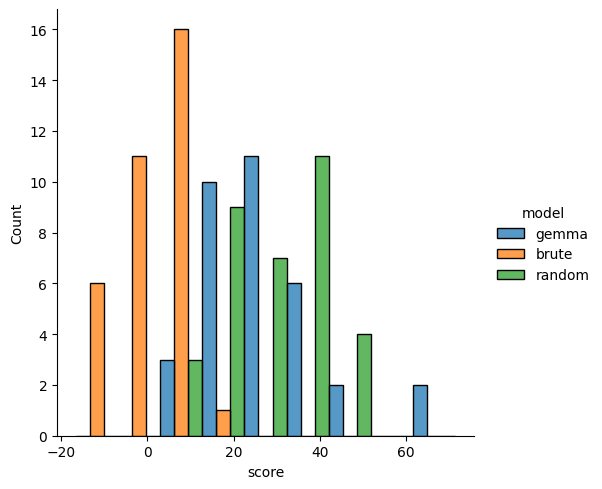

In [266]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [267]:
phi_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/phi3_mini_quotes.csv")
phi_metric = bipartite_metric(phi_model, ground_truth)
phi_metric["score"].mean() 

27.03172215856039

In [268]:
phi = phi_metric.assign(model="phi") 

In [269]:
llm = pd.concat([gemma, phi, brute, random]).reset_index(drop=True)

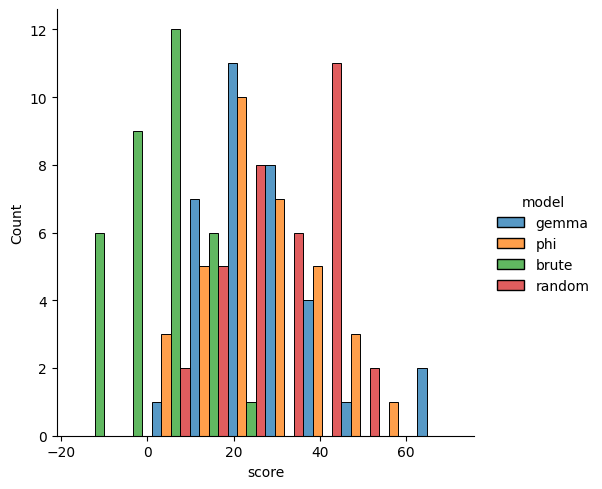

In [270]:
sns.displot(llm, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

Chat_GPT

In [271]:
chatgpt_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/Chat_GPT_results - Sheet1.csv")
chatgpt_model
# chatgpt_model = bipartite_metric(chatgpt_model, ground_truth)
# phi_metric["score"].mean() * 100

,comedian,sentence
0,Jimmy_Yang,"Asian people, we don’t need Tinder anymore. We..."
1,Jimmy_Yang,"I’ve been dating a lot of tall girls lately, b..."
2,Jimmy_Yang,"She’s like, it makes my ass look better. I’m l..."
3,Jimmy_Yang,Last time– the last time I took a tall girl to...
4,Jimmy_Yang,I’m 5′ 5″. I just go to concerts to smell othe...
5,Jimmy_Yang,"She was having the time of her life, doing wha..."
6,Jimmy_Yang,I was frustrated. I had enough. So I just look...
7,Russell_Peters,"He goes, look, you’re a 48-year-old Indian man..."
8,Russell_Peters,There is no way you can be Indian and not have...
9,Russell_Peters,There’s no way you can consume the food that w...


In [272]:
chatgpt_jm = chatgpt_model[chatgpt_model["comedian"] == "John_Mulaney"]
ground_truth_jm = ground_truth[ground_truth["comedian"]== "John_Mulaney"]
# chatgpt_model = bipartite_metric(chatgpt_model, ground_truth)
# phi_metric["score"].mean() * 100

In [273]:
ground_truth_jm

,comedian,laugh_start,laugh_end,sentence
56,John_Mulaney,20.235,22.628,"We made these big piles of clothes, we put the..."
57,John_Mulaney,30.546,32.020,"On an unrelated note, I'm going to walk out th..."
58,John_Mulaney,44.332,46.485,"I was like, ""This one's shirts. I got a bunch ..."
59,John_Mulaney,59.492,67.850,"Dear IRS, please deduct from my federal income..."
60,John_Mulaney,70.762,74.207,"That sleep shirt bullshit. ""Well, if it's too ..."
61,John_Mulaney,100.870,103.899,So rather than violate these meaningless polit...
62,John_Mulaney,113.782,115.980,Why don't you give me a candle for looking in ...


In [274]:
chatgpt_metric_jm = bipartite_metric(chatgpt_jm, ground_truth_jm)
print(chatgpt_metric_jm)

       comedian      score
0  John_Mulaney  70.371429


In [275]:
chatgpt_metric_jm["score"].mean() 

70.37142857142857

In [276]:
model_jm = model[model["comedian"] == "John_Mulaney"]
model_jm = bipartite_metric(model_jm, ground_truth_jm)
model_jm["score"].mean() 

41.357142857142854

## Different Prompts

##### "The following is a stand-up comedy transcript. When performed in front of a live audience, which jokes do you think made the audience laugh?  List of quotes:"

In [277]:
laugh = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/laugh_prompt - Sheet1.csv')

In [278]:
laugh_metric = bipartite_metric(laugh, ground_truth)
laugh_metric

,comedian,score
0,Ali_Wong,24.041667
1,Ali_Wong_2,32.714286
2,Anthony_Jeselnik,18.428571
3,Anthony_Jeselnik_2,70.000000
4,Chelsea_Peretti,14.250000
5,Chelsea_Peretti_2,35.363636
6,Donald_Glover,30.125000
7,Donald_Glover_2,14.312500
8,Hasan_Minhaj,38.000000
9,Hasan_Minhaj_2,19.600000


In [279]:
laugh_metric.mean()

/tmp/ipykernel_3058768/3345081846.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  laugh_metric.mean()


score    28.199806
dtype: float64

#### The following is a stand-up comedy transcript. What are the funniest punchlines from the transcript. List of quotes:"

In [280]:
punchline = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/punchline_prompt - Sheet1.csv')

In [281]:
punchline_metric = bipartite_metric(punchline, ground_truth)
punchline_metric

,comedian,score
0,Ali_Wong,33.000000
1,Ali_Wong_2,34.142857
2,Anthony_Jeselnik,18.785714
3,Anthony_Jeselnik_2,39.750000
4,Chelsea_Peretti,14.250000
5,Chelsea_Peretti_2,22.545455
6,Donald_Glover,19.312500
7,Donald_Glover_2,13.937500
8,Hasan_Minhaj,41.625000
9,Hasan_Minhaj_2,53.700000


In [282]:
punchline_metric.mean()

/tmp/ipykernel_3058768/3771637599.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  punchline_metric.mean()


score    31.266749
dtype: float64

#### Below is a transcript from a stand-up comedy routine. Analyze the transcript and extract the quotes that are most likely to have made the audience laugh. List of quotes:

In [283]:
most_laugh = pd.read_csv('/home/ada/humor/data/stand_up_dataset/prompts/mostlaugh_prompt - Sheet1.csv')

In [284]:
most_laugh_metric = bipartite_metric(most_laugh, ground_truth)
most_laugh_metric

,comedian,score
0,Ali_Wong,48.722222
1,Ali_Wong_2,31.857143
2,Anthony_Jeselnik,19.357143
3,Anthony_Jeselnik_2,33.875000
4,Chelsea_Peretti,14.250000
5,Chelsea_Peretti_2,22.545455
6,Donald_Glover,19.312500
7,Donald_Glover_2,21.812500
8,Hasan_Minhaj,39.500000
9,Hasan_Minhaj_2,34.800000


In [285]:
most_laugh_metric.mean()

/tmp/ipykernel_3058768/3010234896.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  most_laugh_metric.mean()


score    28.137611
dtype: float64

In [286]:
laugh = laugh_metric.assign(model="laugh") 
punchline = punchline_metric.assign(model="punchline")
most_laugh = most_laugh_metric.assign(model="most_laugh")

In [287]:
df = pd.concat([gemma, laugh, punchline, most_laugh]).reset_index(drop=True)

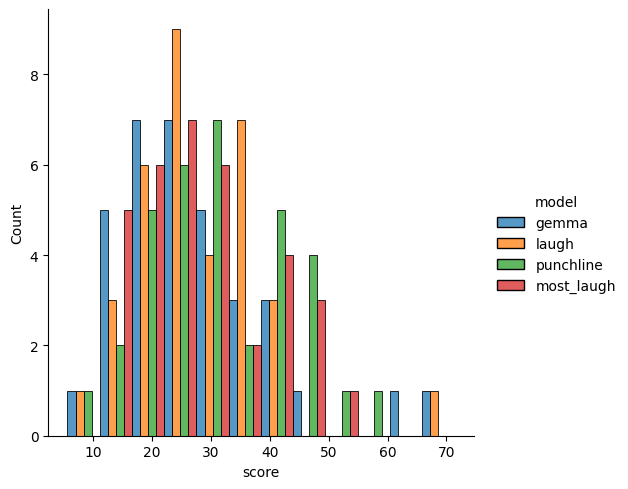

In [288]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [289]:
llm_gt = ground_truth.loc[ground_truth["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Russell_Peters", "Ali_Wong", "Hasan_Minhaj"])]

In [290]:
llm_gt

,comedian,laugh_start,laugh_end,sentence
56,John_Mulaney,20.2350,22.628,"We made these big piles of clothes, we put the..."
57,John_Mulaney,30.5460,32.020,"On an unrelated note, I'm going to walk out th..."
58,John_Mulaney,44.3320,46.485,"I was like, ""This one's shirts. I got a bunch ..."
59,John_Mulaney,59.4920,67.850,"Dear IRS, please deduct from my federal income..."
60,John_Mulaney,70.7620,74.207,"That sleep shirt bullshit. ""Well, if it's too ..."
61,John_Mulaney,100.8700,103.899,So rather than violate these meaningless polit...
62,John_Mulaney,113.7820,115.980,Why don't you give me a candle for looking in ...
77,Ali_Wong,21.0070,28.986,We were screaming and fighting and yelling and...
78,Ali_Wong,48.8030,51.189,We were all required to buy it when we were in...
79,Ali_Wong,56.7800,60.001,All because what? It could graph.


In [292]:
chatgpt

,comedian,sentence
0,Jimmy_Yang,"Asian people, we don’t need Tinder anymore. We..."
1,Jimmy_Yang,"I’ve been dating a lot of tall girls lately, b..."
2,Jimmy_Yang,"She’s like, it makes my ass look better. I’m l..."
3,Jimmy_Yang,Last time– the last time I took a tall girl to...
4,Jimmy_Yang,I’m 5′ 5″. I just go to concerts to smell othe...
5,Jimmy_Yang,"She was having the time of her life, doing wha..."
6,Jimmy_Yang,I was frustrated. I had enough. So I just look...
7,Russell_Peters,"He goes, look, you’re a 48-year-old Indian man..."
8,Russell_Peters,There is no way you can be Indian and not have...
9,Russell_Peters,There’s no way you can consume the food that w...


In [293]:
chatgpt_metric = bipartite_metric(chatgpt, llm_gt)
chatgpt_metric

,comedian,score
0,Ali_Wong,41.750000
1,Hasan_Minhaj,39.625000
2,Jimmy_Yang,47.600000
3,John_Mulaney,70.571429
4,Russell_Peters,41.300000


In [294]:
chatgpt_metric.mean()

/tmp/ipykernel_3058768/1572520876.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  chatgpt_metric.mean()


score    48.169286
dtype: float64

In [295]:
claude = pd.read_csv("/home/ada/humor/data/stand_up_dataset/Claude_results - Sheet1.csv")

In [296]:
claude_metric = bipartite_metric(claude, llm_gt)
claude_metric

,comedian,score
0,Ali_Wong,60.333333
1,Hasan_Minhaj,63.250000
2,Jimmy_Yang,36.400000
3,John_Mulaney,57.000000
4,Russell_Peters,46.800000


In [297]:
claude_metric.mean()

/tmp/ipykernel_3058768/2380763216.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  claude_metric.mean()


score    52.756667
dtype: float64

In [298]:
gemma_llm = model.loc[model["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Russell_Peters", "Ali_Wong", "Hasan_Minhaj"])]

In [299]:
gemma_llm_metric = bipartite_metric(gemma_llm, llm_gt)
gemma_llm_metric.mean()

/tmp/ipykernel_3058768/1130048052.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma_llm_metric.mean()


score    30.884762
dtype: float64

In [300]:
gemma = gemma_llm_metric.assign(model = "gemma")
claude = claude_metric.assign(model="claude") 
chatgpt = chatgpt_metric.assign(model="chatgpt")

In [301]:
df = pd.concat([gemma, claude, chatgpt]).reset_index(drop=True)

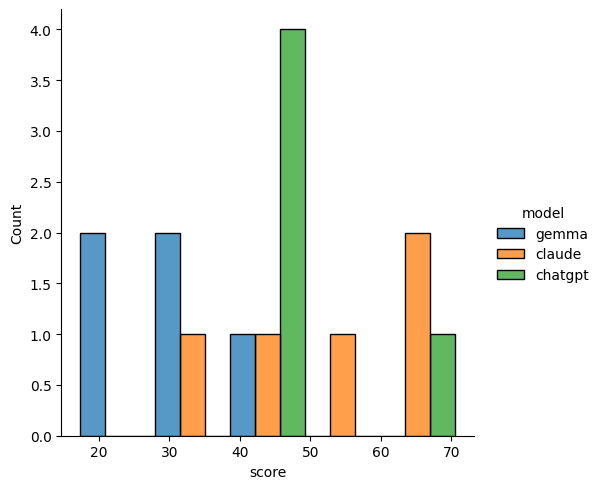

In [302]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

## More tokens

In [303]:
gemma200 = pd.read_csv("/home/ada/humor/data/stand_up_dataset/gemma200tokens - Sheet1.csv")

In [304]:
gemma200_metric = bipartite_metric(gemma200, ground_truth)
gemma200_metric

,comedian,score
0,Ali_Wong,32.333333
1,Ali_Wong_2,40.285714
2,Anthony_Jeselnik,30.642857
3,Anthony_Jeselnik_2,63.250000
4,Chelsea_Peretti,14.333333
5,Chelsea_Peretti_2,31.636364
6,Donald_Glover,36.500000
7,Donald_Glover_2,35.875000
8,Hasan_Minhaj,36.250000
9,Hasan_Minhaj_2,25.500000


In [305]:
gemma200_metric.mean()

/tmp/ipykernel_3058768/568904367.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma200_metric.mean()


score    32.047586
dtype: float64

In [306]:
gemma_metric = bipartite_metric(model, ground_truth)
gemma_metric.mean()

/tmp/ipykernel_3058768/1305976714.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma_metric.mean()


score    28.171599
dtype: float64

In [307]:
gemma = gemma_metric.assign(model = "gemma")
gemma200 = gemma200_metric.assign(model="gemma200") 


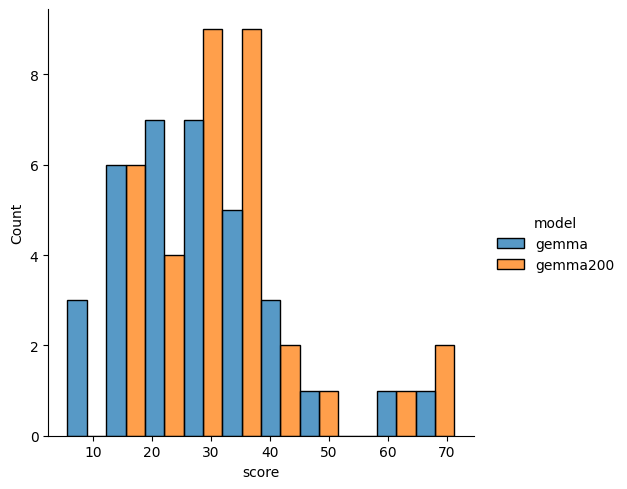

In [308]:
sns.displot(pd.concat([gemma, gemma200]).reset_index(drop=True), x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

# Play pretend

In [309]:
comedian_pretend = pd.read_csv("/home/ada/humor/data/stand_up_dataset/comedian_quotes - Sheet1.csv")
comedian_pretend_metric = bipartite_metric(comedian_pretend, ground_truth)
comedian_pretend_metric

,comedian,score
0,Ali_Wong,15.583333
1,Ali_Wong_2,54.571429
2,Anthony_Jeselnik,24.571429
3,Anthony_Jeselnik_2,39.750000
4,Chelsea_Peretti,14.333333
5,Chelsea_Peretti_2,31.636364
6,Donald_Glover,23.500000
7,Donald_Glover_2,13.125000
8,Hasan_Minhaj,39.375000
9,Hasan_Minhaj_2,38.500000


In [310]:
comedian_pretend_metric.mean()

/tmp/ipykernel_3058768/1875112182.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  comedian_pretend_metric.mean()


score    28.529787
dtype: float64

In [311]:
comedyfan_pretend = pd.read_csv("/home/ada/humor/data/stand_up_dataset/comedy_fan_laughter_quotes - Sheet1.csv")
comedyfan_pretend_metric = bipartite_metric(comedyfan_pretend, ground_truth)
comedyfan_pretend_metric

,comedian,score
0,Ali_Wong,15.583333
1,Ali_Wong_2,42.428571
2,Anthony_Jeselnik,24.571429
3,Anthony_Jeselnik_2,63.000000
4,Chelsea_Peretti,14.333333
5,Chelsea_Peretti_2,31.636364
6,Donald_Glover,23.500000
7,Donald_Glover_2,13.125000
8,Hasan_Minhaj,26.875000
9,Hasan_Minhaj_2,38.500000


In [312]:
comedyfan_pretend_metric.mean()

/tmp/ipykernel_3058768/3683433526.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  comedyfan_pretend_metric.mean()


score    28.227768
dtype: float64

In [313]:
comedycritic_pretend = pd.read_csv("/home/ada/humor/data/stand_up_dataset/comedy_critic_quotes - Sheet1.csv")
comedycritic_pretend_metric = bipartite_metric(comedycritic_pretend, ground_truth)
comedycritic_pretend_metric

,comedian,score
0,Ali_Wong,33.916667
1,Ali_Wong_2,40.285714
2,Anthony_Jeselnik,24.571429
3,Anthony_Jeselnik_2,63.000000
4,Chelsea_Peretti,14.333333
5,Chelsea_Peretti_2,31.636364
6,Donald_Glover,23.500000
7,Donald_Glover_2,13.125000
8,Hasan_Minhaj,15.000000
9,Hasan_Minhaj_2,38.500000


In [314]:
comedycritic_pretend_metric.mean()

/tmp/ipykernel_3058768/2664976109.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  comedycritic_pretend_metric.mean()


score    29.085821
dtype: float64

In [315]:
gemma = gemma_llm_metric.assign(model = "gemma")
fan = comedyfan_pretend_metric.assign(model="fan") 
comedian = comedian_pretend_metric.assign(model="comedian") 
critic = comedycritic_pretend_metric.assign(model="critic")

In [316]:
df = pd.concat([gemma, fan, comedian, critic]).reset_index(drop=True)

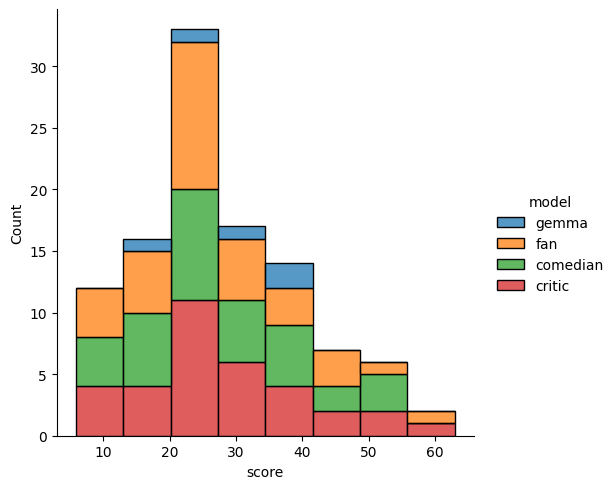

In [317]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="stack")

## Decoding

Top-K

In [318]:
top_k = pd.read_csv("/home/ada/humor/data/stand_up_dataset/k_sample - Sheet1.csv")

In [319]:
top_k_df = {}
for i in range(1, 11):
    top_k_df[f'df_k_{i}'] = top_k[top_k['k'] == i]


In [320]:
k_1 = top_k_df['df_k_1']
k_2 = top_k_df['df_k_2']
k_3 = top_k_df['df_k_3']
k_4 = top_k_df['df_k_4']
k_5 = top_k_df['df_k_5']
k_6 = top_k_df['df_k_6']
k_7 = top_k_df['df_k_7']
k_8 = top_k_df['df_k_8']
k_9 = top_k_df['df_k_9']
k_10 = top_k_df['df_k_10']

In [321]:
k1_metric = bipartite_metric(k_1, ground_truth)
k1_metric.mean()

/tmp/ipykernel_3058768/2551170758.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k1_metric.mean()


score    28.52265
dtype: float64

In [322]:
k2_metric = bipartite_metric(k_2, ground_truth)
k2_metric.mean()

/tmp/ipykernel_3058768/2657943919.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k2_metric.mean()


score    27.251133
dtype: float64

In [323]:
k3_metric = bipartite_metric(k_3, ground_truth)
k3_metric.mean()

/tmp/ipykernel_3058768/1990443186.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k3_metric.mean()


score    23.67733
dtype: float64

In [324]:
k4_metric = bipartite_metric(k_4, ground_truth)
k4_metric.mean()

/tmp/ipykernel_3058768/2657779777.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k4_metric.mean()


score    27.376129
dtype: float64

In [325]:
k5_metric = bipartite_metric(k_5, ground_truth)
k5_metric.mean()

/tmp/ipykernel_3058768/1940522433.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k5_metric.mean()


score    25.972393
dtype: float64

In [326]:
k6_metric = bipartite_metric(k_6, ground_truth)
k6_metric.mean()

/tmp/ipykernel_3058768/797404915.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k6_metric.mean()


score    24.944079
dtype: float64

In [327]:
k7_metric = bipartite_metric(k_7, ground_truth)
k7_metric.mean()

/tmp/ipykernel_3058768/661257255.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k7_metric.mean()


score    24.226357
dtype: float64

In [328]:
k8_metric = bipartite_metric(k_8, ground_truth)
k8_metric.mean()

/tmp/ipykernel_3058768/2862372342.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k8_metric.mean()


score    21.191748
dtype: float64

In [329]:
k9_metric = bipartite_metric(k_9, ground_truth)
k9_metric.mean()

/tmp/ipykernel_3058768/1132242517.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k9_metric.mean()


score    26.669631
dtype: float64

In [330]:
k10_metric = bipartite_metric(k_10, ground_truth)
k10_metric.mean()

/tmp/ipykernel_3058768/3968851987.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  k10_metric.mean()


score    27.783185
dtype: float64

In [331]:
k1 = k1_metric.assign(model = "k=1")
k2 = k2_metric.assign(model = "k=2")
k3 = k3_metric.assign(model = "k=3")
k4 = k4_metric.assign(model = "k=4")
k5 = k5_metric.assign(model = "k=5")
k6 = k6_metric.assign(model = "k=6")
k7 = k7_metric.assign(model = "k=7")
k8 = k8_metric.assign(model = "k=8")
k9 = k9_metric.assign(model = "k=9")
k10 = k10_metric.assign(model = "k=10")

In [332]:
df = pd.concat([k1, k2, k3, k4, k5, k6, k7, k8, k9, k10]).reset_index(drop=True)

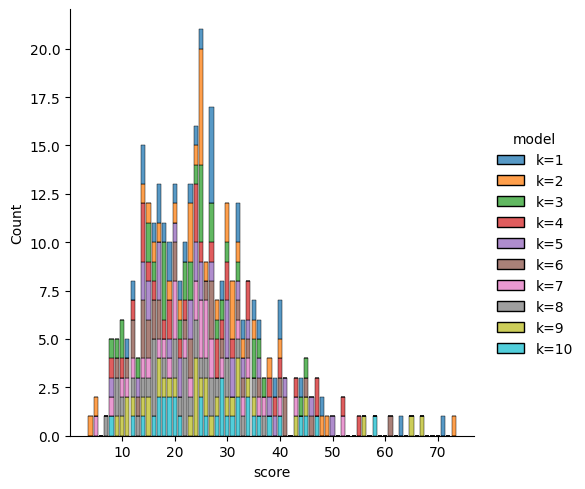

In [333]:
sns.displot(df, x="score", hue="model", kind="hist", multiple="stack", shrink=0.8, binwidth=1.0)

In [334]:
k1_metric

,comedian,score
0,Ali_Wong,39.166667
1,Ali_Wong_2,40.428571
2,Anthony_Jeselnik,18.714286
3,Anthony_Jeselnik_2,63.250000
4,Chelsea_Peretti,14.333333
5,Chelsea_Peretti_2,31.636364
6,Donald_Glover,23.500000
7,Donald_Glover_2,18.125000
8,Hasan_Minhaj,36.250000
9,Hasan_Minhaj_2,25.400000


<AxesSubplot:xlabel='variable', ylabel='value'>

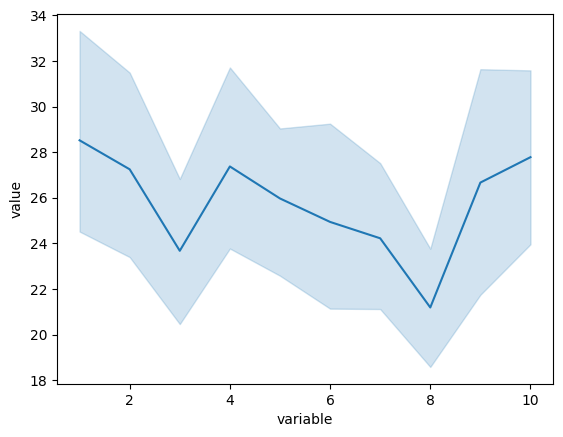

In [335]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

k_vals = pd.DataFrame({
    1: k1_metric["score"],
    2: k2_metric["score"],
    3: k3_metric["score"],
    4: k4_metric["score"],
    5: k5_metric["score"],
    6: k6_metric["score"],
    7: k7_metric["score"],
    8: k8_metric["score"],
    9: k9_metric["score"],
    10: k10_metric["score"],
}).melt()

sns.lineplot(k_vals, x="variable", y="value")

# plt.figure(figsize=(10, 6))
# plt.plot(k_values, means, marker='o', linestyle='-', color='pink')

# plt.title('Mean Metrics for k Values from 1 to 10')
# plt.xlabel('k Value')
# plt.ylabel('Mean Metric')
# plt.xticks(k_values)
# plt.legend()
# plt.grid(True)
# plt.show()

## Top-p

In [336]:
top_p = pd.read_csv("/home/ada/humor/data/stand_up_dataset/p_sample - Sheet1.csv")

In [337]:
top_p

,comedian,sentence,p
0,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge...",0.00
1,Anthony_Jeselnik,My mom actually should’ve been on one of the p...,0.00
2,Anthony_Jeselnik,"When I was a kid, like nine years old, I’d com...",0.00
3,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge...",0.90
4,Anthony_Jeselnik,My mom actually should’ve been on one of the p...,0.90
...,...,...,...
1416,Tom_Segura_2,"There's ""Hold Open,"" and ""Close."" And you can ...",0.98
1417,Tom_Segura_2,I got such a warm rush through my body. It fel...,0.99
1418,Tom_Segura_2,"There’s “Hold Open,” and “Close.” And you can ...",0.99
1419,Tom_Segura_2,I got such a warm rush through my body. It fel...,1.00


In [338]:
top_p_df = {}
for p in [0] + [i / 100 for i in range(90, 101)]:
    top_p_df[f'df_p_{p}'] = top_p[top_p['p'] == p]

In [339]:
p_0 = top_p_df['df_p_0']
p_9 = top_p_df['df_p_0.9']
p_91 = top_p_df['df_p_0.91']
p_92 = top_p_df['df_p_0.92']
p_93 = top_p_df['df_p_0.93']
p_94 = top_p_df['df_p_0.94']
p_95 = top_p_df['df_p_0.95']
p_96 = top_p_df['df_p_0.96']
p_97 = top_p_df['df_p_0.97']
p_98 = top_p_df['df_p_0.98']
p_99 = top_p_df['df_p_0.99']
p_1 = top_p_df['df_p_1.0']

In [340]:
p0_metric = bipartite_metric(p_0, ground_truth)
p0_metric.mean()

/tmp/ipykernel_3058768/1682444344.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p0_metric.mean()


score    27.379273
dtype: float64

In [341]:
p9_metric = bipartite_metric(p_9, ground_truth)
p9_metric.mean()

/tmp/ipykernel_3058768/737289714.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p9_metric.mean()


score    27.194199
dtype: float64

In [342]:
p91_metric = bipartite_metric(p_91, ground_truth)
p91_metric.mean()

/tmp/ipykernel_3058768/1267983535.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p91_metric.mean()


score    26.275467
dtype: float64

In [343]:
p92_metric = bipartite_metric(p_92, ground_truth)
p92_metric.mean()

/tmp/ipykernel_3058768/3663633955.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p92_metric.mean()


score    23.657059
dtype: float64

In [344]:
p93_metric = bipartite_metric(p_93, ground_truth)
p93_metric.mean()

/tmp/ipykernel_3058768/3124393155.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p93_metric.mean()


score    25.995927
dtype: float64

In [345]:
p94_metric = bipartite_metric(p_94, ground_truth)
p94_metric.mean()

/tmp/ipykernel_3058768/1826973090.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p94_metric.mean()


score    26.230278
dtype: float64

In [346]:
p95_metric = bipartite_metric(p_95, ground_truth)
p95_metric.mean()

/tmp/ipykernel_3058768/2858370961.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p95_metric.mean()


score    28.186645
dtype: float64

In [347]:
p96_metric = bipartite_metric(p_96, ground_truth)
p96_metric.mean()

/tmp/ipykernel_3058768/3544092099.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p96_metric.mean()


score    26.207954
dtype: float64

In [348]:
p97_metric = bipartite_metric(p_97, ground_truth)
p97_metric.mean()

/tmp/ipykernel_3058768/1387252451.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p97_metric.mean()


score    24.471526
dtype: float64

In [349]:
p98_metric = bipartite_metric(p_98, ground_truth)
p98_metric.mean()

/tmp/ipykernel_3058768/63609148.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p98_metric.mean()


score    26.460454
dtype: float64

In [350]:
p99_metric = bipartite_metric(p_99, ground_truth)
p99_metric.mean()

/tmp/ipykernel_3058768/2626852736.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p99_metric.mean()


score    28.493097
dtype: float64

In [351]:
p1_metric = bipartite_metric(p_1, ground_truth)
p1_metric.mean()

/tmp/ipykernel_3058768/2209821856.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p1_metric.mean()


score    27.080706
dtype: float64

In [352]:
p0 = p0_metric.assign(model = "p=0")
p9 = p9_metric.assign(model = "p=9")
p91 = p91_metric.assign(model = "p=91")
p92 = p92_metric.assign(model = "p=92")
p93 = p93_metric.assign(model = "p=93")
p94 = p94_metric.assign(model = "p=94")
p95 = p95_metric.assign(model = "p=95")
p96 = p96_metric.assign(model = "p=96")
p97 = p97_metric.assign(model = "p=97")
p98 = p98_metric.assign(model = "p=98")
p99 = p99_metric.assign(model = "p=99")
p1 = p1_metric.assign(model = "p=1")

In [353]:
df = pd.concat([p0, p9, p91, p92, p93, p94, p95, p96, p97, p98, p99, p1]).reset_index(drop=True)

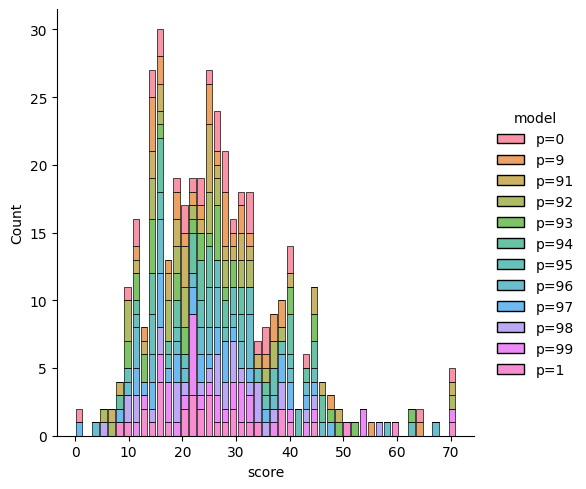

In [354]:
sns.displot(df, x="score", hue="model", kind="hist", multiple="stack", shrink=0.8, binwidth=1.5)

/tmp/ipykernel_3058768/2157746874.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p9_metric.mean(),
/tmp/ipykernel_3058768/2157746874.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p91_metric.mean(),
/tmp/ipykernel_3058768/2157746874.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p92_metric.mean(),
/tmp/ipykernel_3058768/2157746874.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this w

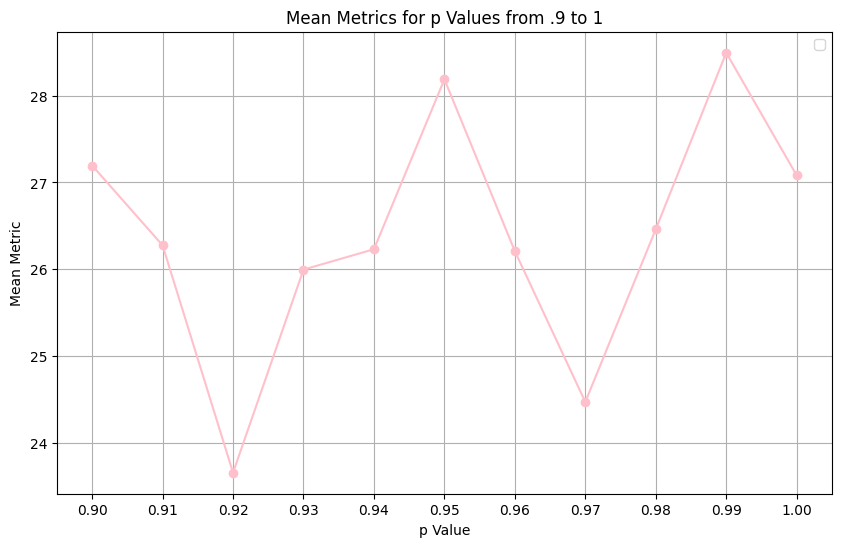

In [355]:
import matplotlib.pyplot as plt

means_p = [
    p9_metric.mean(),
    p91_metric.mean(),
    p92_metric.mean(),
    p93_metric.mean(),
    p94_metric.mean(),
    p95_metric.mean(),
    p96_metric.mean(),
    p97_metric.mean(),
    p98_metric.mean(),
    p99_metric.mean(),
    p1_metric.mean()
]

p_values = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]

# Plotting the means
plt.figure(figsize=(10, 6))
plt.plot(p_values, means_p, marker='o', linestyle='-', color='pink')

plt.title('Mean Metrics for p Values from .9 to 1')
plt.xlabel('p Value')
plt.ylabel('Mean Metric')
plt.xticks(p_values)
plt.legend()
plt.grid(True)
plt.show()


## P = i/10

In [356]:
top_p2 = pd.read_csv("/home/ada/humor/data/stand_up_dataset/p_sample_i_10 - Sheet1.csv")

In [357]:
top_p2

,comedian,sentence,p
0,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge...",0.1
1,Anthony_Jeselnik,My mom actually should’ve been on one of the p...,0.1
2,Anthony_Jeselnik,"When I was a kid, like nine years old, I’d com...",0.1
3,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge...",0.2
4,Anthony_Jeselnik,My mom actually should’ve been on one of the p...,0.2
...,...,...,...
1196,Tom_Segura_2,"There’s “Hold Open,” and “Close.” And you can ...",0.8
1197,Tom_Segura_2,I got such a warm rush through my body. It fel...,0.9
1198,Tom_Segura_2,"I was trying to figure out, “Why does this fee...",0.9
1199,Tom_Segura_2,I got such a warm rush through my body. It fel...,1.0


In [358]:
top_p_df = {}
for p in [(i / 10) for i in range(1, 11)]:
    top_p_df[f'df_p_{p}'] = top_p2[top_p2['p'] == p]

In [359]:
top_p_df

{'df_p_0.1':                 comedian                                           sentence  \
 0       Anthony_Jeselnik  When I was a kid, I used to fantasize about ge...   
 1       Anthony_Jeselnik  My mom actually should’ve been on one of the p...   
 2       Anthony_Jeselnik  When I was a kid, like nine years old, I’d com...   
 33    Anthony_Jeselnik_2  I've never talked to a group of people without...   
 34    Anthony_Jeselnik_2  And I know my grandma loved it too, because it...   
 ...                  ...                                                ...   
 1129          Tom_Segura  I'll go get it. You stay here and watch my place.   
 1130          Tom_Segura                                  That's what's up.   
 1131          Tom_Segura  Can we get a description before we agree to te...   
 1181        Tom_Segura_2  I got such a warm rush through my body. It fel...   
 1182        Tom_Segura_2  There’s “Hold Open,” and “Close.” And you can ...   
 
         p  
 0     0.1  


In [360]:
p_1 = top_p_df['df_p_0.1']
p_2 = top_p_df['df_p_0.2']
p_3 = top_p_df['df_p_0.3']
p_4 = top_p_df['df_p_0.4']
p_5 = top_p_df['df_p_0.5']
p_6 = top_p_df['df_p_0.6']
p_7 = top_p_df['df_p_0.7']
p_8 = top_p_df['df_p_0.8']
p_9 = top_p_df['df_p_0.9']
p_10 = top_p_df['df_p_1.0']


In [361]:
p1_metric = bipartite_metric(p_1, ground_truth)
p1_metric.mean()

/tmp/ipykernel_3058768/2209821856.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p1_metric.mean()


score    27.786486
dtype: float64

In [362]:
p2_metric = bipartite_metric(p_2, ground_truth)
p2_metric.mean()

/tmp/ipykernel_3058768/1013454562.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p2_metric.mean()


score    27.230931
dtype: float64

In [363]:
p3_metric = bipartite_metric(p_3, ground_truth)
p3_metric.mean()

/tmp/ipykernel_3058768/3040445040.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p3_metric.mean()


score    27.492369
dtype: float64

In [364]:
p4_metric = bipartite_metric(p_4, ground_truth)
p4_metric.mean()

/tmp/ipykernel_3058768/2210139453.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p4_metric.mean()


score    27.593454
dtype: float64

In [365]:
p5_metric = bipartite_metric(p_5, ground_truth)
p5_metric.mean()

/tmp/ipykernel_3058768/2477612699.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p5_metric.mean()


score    26.327575
dtype: float64

In [366]:
p6_metric = bipartite_metric(p_6, ground_truth)
p6_metric.mean()

/tmp/ipykernel_3058768/2064950480.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p6_metric.mean()


score    27.99158
dtype: float64

In [367]:
p7_metric = bipartite_metric(p_7, ground_truth)
p7_metric.mean()

/tmp/ipykernel_3058768/587685005.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p7_metric.mean()


score    27.625315
dtype: float64

In [368]:
p8_metric = bipartite_metric(p_8, ground_truth)
p8_metric.mean()

/tmp/ipykernel_3058768/4050173542.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p8_metric.mean()


score    26.171239
dtype: float64

In [369]:
p9_metric = bipartite_metric(p_9, ground_truth)
p9_metric.mean()

/tmp/ipykernel_3058768/737289714.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p9_metric.mean()


score    26.862384
dtype: float64

In [370]:
p10_metric = bipartite_metric(p_10, ground_truth)
p10_metric.mean()

/tmp/ipykernel_3058768/2502552817.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  p10_metric.mean()


score    26.533175
dtype: float64

<AxesSubplot:xlabel='variable', ylabel='value'>

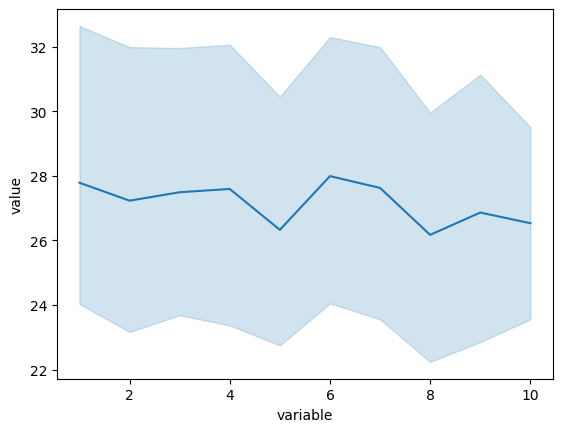

In [371]:
p_vals = pd.DataFrame({
    1: p1_metric["score"],
    2: p2_metric["score"],
    3: p3_metric["score"],
    4: p4_metric["score"],
    5: p5_metric["score"],
    6: p6_metric["score"],
    7: p7_metric["score"],
    8: p8_metric["score"],
    9: p9_metric["score"],
    10: p10_metric["score"],
}).melt()

sns.lineplot(p_vals, x="variable", y="value")

## Play Pretend

In [372]:
llm_gt = ground_truth.loc[ground_truth["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Joe_List","Anthony_Jeselnik", "Ali_Wong", "Hasan_Minhaj"])]

In [373]:
pretend_gemma = pd.read_csv("/home/ada/humor/data/stand_up_dataset/play pretend - Sheet1.csv")
pretend_gpt = pd.read_csv("/home/ada/humor/data/stand_up_dataset/play pretend chatgpt - Sheet1.csv")
normal_gpt = pd.read_csv("/home/ada/humor/data/stand_up_dataset/nopretend chatgpt - Sheet1.csv")

In [374]:
gemma_metric = bipartite_metric(model, ground_truth)
gemma_metric.mean()

/tmp/ipykernel_3058768/1305976714.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma_metric.mean()


score    28.171599
dtype: float64

In [375]:
pretend_gemma_metric = bipartite_metric(pretend_gemma, ground_truth)
pretend_gemma_metric.mean()

/tmp/ipykernel_3058768/838986874.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pretend_gemma_metric.mean()


score    27.51311
dtype: float64

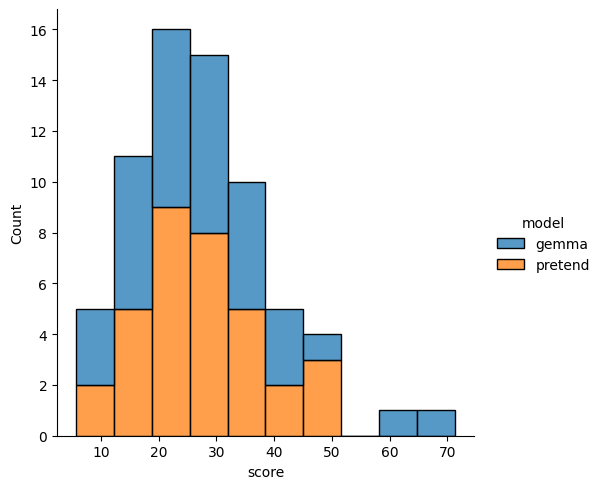

In [376]:
pretend_gemma = pretend_gemma_metric.assign(model="pretend")
gemma = gemma_metric.assign(model="gemma")
df = pd.concat([gemma, pretend_gemma]).reset_index(drop=True)
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="stack")

In [377]:
normal_gpt_metric = bipartite_metric(normal_gpt, llm_gt)
normal_gpt_metric.mean()

/tmp/ipykernel_3058768/1099743959.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normal_gpt_metric.mean()


score    40.020635
dtype: float64

In [378]:
pretend_gpt_metric = bipartite_metric(pretend_gpt, llm_gt)
pretend_gpt_metric.mean()

/tmp/ipykernel_3058768/1170378115.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pretend_gpt_metric.mean()


score    42.805456
dtype: float64

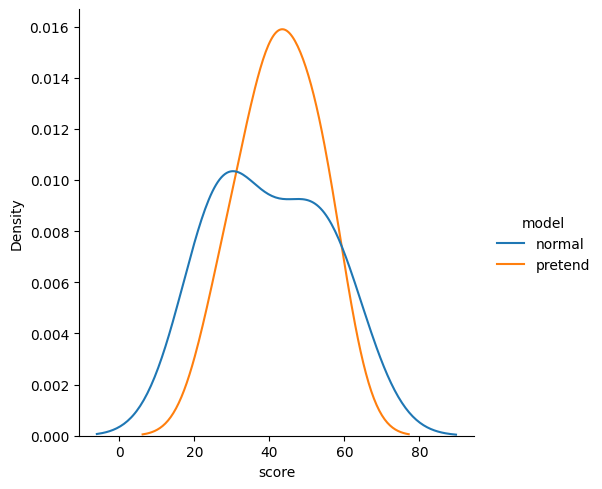

In [379]:
pretend = pretend_gpt_metric.assign(model="pretend")
normal = normal_gpt_metric.assign(model="normal")
df = pd.concat([normal, pretend]).reset_index(drop=True)
sns.displot(df, x="score", hue="model", kind="kde")

In [380]:
pretend_gemma = pd.read_csv("/home/ada/humor/data/stand_up_dataset/play pretend - Sheet1.csv")

In [381]:
llm_gemma = model.loc[model["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Joe_List","Anthony_Jeselnik", "Ali_Wong", "Hasan_Minhaj"])]
llm_pretend_gemma = pretend_gemma.loc[pretend_gemma["comedian"].isin(["John_Mulaney", "Jimmy_Yang", "Joe_List","Anthony_Jeselnik", "Ali_Wong", "Hasan_Minhaj"])]

In [382]:
llm_pretend_gemma_metric = bipartite_metric(llm_pretend_gemma, llm_gt)
llm_pretend_gemma_metric.mean()

/tmp/ipykernel_3058768/1485451137.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  llm_pretend_gemma_metric.mean()


score    29.149603
dtype: float64

In [383]:
llm_gemma_metric = bipartite_metric(llm_gemma, llm_gt)
llm_gemma_metric.mean()

/tmp/ipykernel_3058768/2696414140.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  llm_gemma_metric.mean()


score    30.254861
dtype: float64

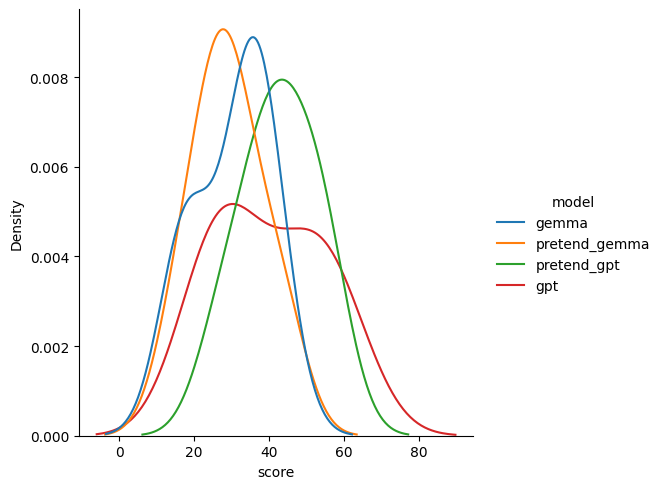

In [384]:
pretend_gemma = llm_pretend_gemma_metric.assign(model="pretend_gemma")
gemma = llm_gemma_metric.assign(model="gemma")
pretend_gpt = pretend_gpt_metric.assign(model="pretend_gpt")
normal_gpt = normal_gpt_metric.assign(model="gpt")
df = pd.concat([gemma, pretend_gemma, pretend_gpt, normal_gpt]).reset_index(drop=True)
sns.displot(df, x="score", hue="model", kind="kde")

Gemma 2

In [385]:
gemma2 = pd.read_csv("/home/ada/humor/data/stand_up_dataset/gemma2 - gemma2.csv")

In [386]:
gemma2_metric = bipartite_metric(gemma2, ground_truth)
gemma2_metric.mean()

/tmp/ipykernel_3058768/3605705645.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  gemma2_metric.mean()


score    33.330124
dtype: float64

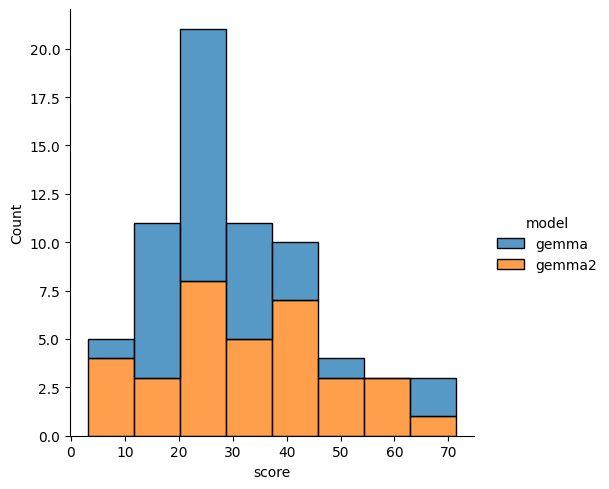

In [387]:
gemma = gemma_metric.assign(model="gemma")
gemma2 = gemma2_metric.assign(model = "gemma2")
df = pd.concat([gemma, gemma2]).reset_index(drop=True)
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="stack")

Llama

In [388]:
llama = pd.read_csv("/home/ada/humor/notebooks/llama - llama.csv")

In [389]:
llama_metric = bipartite_metric(llama, ground_truth)
llama_metric.mean()

/tmp/ipykernel_3058768/422339899.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  llama_metric.mean()


score    31.507007
dtype: float64

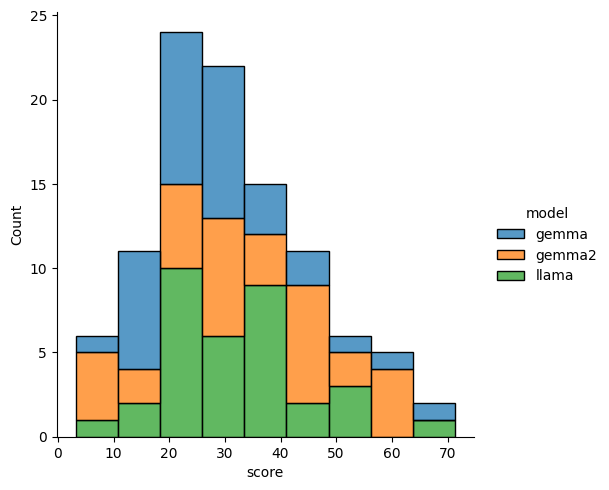

In [390]:
gemma = gemma_metric.assign(model="gemma")
gemma2 = gemma2_metric.assign(model = "gemma2")
llama = llama_metric.assign(model = "llama")
df = pd.concat([gemma, gemma2, llama]).reset_index(drop=True)
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="stack")